<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Subreddit Classifier with Webscraping, NLP and ML
## Part 2: Preprocessing & EDA

## Contents:
1. [Import data](#Import-data)
2. [Preprocessing](#Preprocessing)
3. [Stop Words Removal](#Stop-Words-Removal)
4. [Porter Stemming](#Porter-Stemming)
5. [Lemmatizer](#Lemmatizer)
6. [Feature Engineering](#Feature-Engineering)
7. [EDA](#EDA)
8. [N-grams](#N-grams)
9. [Export to csv](#Export-to-csv)

In [1]:
# Import libraries
import requests
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from nltk.corpus import stopwords

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline
sns.set(font_scale=1.5)
sns.set_style('white')

## Import data
*Back to [Contents](#Contents:)*

In [2]:
df_bicycling = pd.read_csv('./data/bicycling_subreddit.csv')
df_motorcycles = pd.read_csv('./data/motorcycles_subreddit.csv')

In [3]:
# look at bicycle dataframe
df_bicycling.head()

,subreddit,selftext,title,text
0,bicycling,NaN,$10 off any RoadID,$10 off any RoadID
1,bicycling,NaN,Is this a good deal on a bike? It’s a Fuji Thr...,Is this a good deal on a bike? It’s a Fuji Thr...
2,bicycling,"Hi, so there's been a string of bike theft in ...",Preventing Bike Theft,"Hi, so there's been a string of bike theft in ..."
3,bicycling,NaN,Specialized Hardrock. Winnipeg Red River singl...,Specialized Hardrock. Winnipeg Red River singl...
4,bicycling,NaN,Specialized Hardrock. Winnipeg Red river Canop...,Specialized Hardrock. Winnipeg Red river Canop...


In [4]:
# check nulls in bicycle dataframe
df_bicycling.isnull().sum()

subreddit       0
selftext     1741
title           0
text            0
dtype: int64

In [5]:
# check shape in bicycle dataframe
df_bicycling.shape

(2904, 4)

In [6]:
# look at motorcycle dataframe
df_motorcycles.head()

,subreddit,selftext,title,text
0,motorcycles,Hey everyone. \nThe time has come to replace t...,Anyone Running An XL Hornet X2 /w 13mm Crown Pad?,Hey everyone. \nThe time has come to replace t...
1,motorcycles,I just recently bought a 2022 R7 anniversary e...,Breaking in a R7,I just recently bought a 2022 R7 anniversary e...
2,motorcycles,"When I dropped my bike last time, this tube be...",Where does this line connect to? 2004 Ninja ZX636,"When I dropped my bike last time, this tube be..."
3,motorcycles,I want to tell my boyfriend I’m worried about ...,Do you never tell a biker you’re worried about...,I want to tell my boyfriend I’m worried about ...
4,motorcycles,I just recently got my 2021 R3 and have been l...,R3 Exhaust,I just recently got my 2021 R3 and have been l...


In [7]:
# check nulls in motorcycles dataframe
df_motorcycles.isnull().sum()

subreddit      0
selftext     550
title          0
text           0
dtype: int64

In [8]:
# check shape in motorcycle dataframe
df_motorcycles.shape

(2482, 4)

In [9]:
# concat both dataframes into one
df = pd.concat([df_bicycling,df_motorcycles], axis=0, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5386 entries, 0 to 5385
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  5386 non-null   object
 1   selftext   3095 non-null   object
 2   title      5386 non-null   object
 3   text       5386 non-null   object
dtypes: object(4)
memory usage: 168.4+ KB


In [10]:
df.shape

(5386, 4)

In [11]:
df.drop_duplicates('text',inplace=True)

In [12]:
df.head()

,subreddit,selftext,title,text
0,bicycling,NaN,$10 off any RoadID,$10 off any RoadID
1,bicycling,NaN,Is this a good deal on a bike? It’s a Fuji Thr...,Is this a good deal on a bike? It’s a Fuji Thr...
2,bicycling,"Hi, so there's been a string of bike theft in ...",Preventing Bike Theft,"Hi, so there's been a string of bike theft in ..."
3,bicycling,NaN,Specialized Hardrock. Winnipeg Red River singl...,Specialized Hardrock. Winnipeg Red River singl...
4,bicycling,NaN,Specialized Hardrock. Winnipeg Red river Canop...,Specialized Hardrock. Winnipeg Red river Canop...


## Preprocessing 
- Removing url, special characters & tokenizing

*Back to [Contents](#Contents:)*

In [13]:
# Remove urls in text
df['text'] = df['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|\
(?:%[0-9a-fA-F][0-9a-fA-F]))+', '')

C:\Users\finan\AppData\Local\Temp/ipykernel_3364/3629698539.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|\


In [14]:
# Only find words in English characters
tokenizer = RegexpTokenizer(r'[A-Za-z0-9]+') 

In [15]:
# "Run" Tokenizer
df['tokens'] = df.apply(lambda row: tokenizer.tokenize(row['text'].lower()),axis=1)

In [16]:
# Remove rows if tokens in row are empty
df = df[df['tokens'].apply(lambda x: len(x)!=0)]
df.reset_index()

,index,subreddit,selftext,title,text,tokens
0,0,bicycling,NaN,$10 off any RoadID,$10 off any RoadID,"[10, off, any, roadid]"
1,1,bicycling,NaN,Is this a good deal on a bike? It’s a Fuji Thr...,Is this a good deal on a bike? It’s a Fuji Thr...,"[is, this, a, good, deal, on, a, bike, it, s, ..."
2,2,bicycling,"Hi, so there's been a string of bike theft in ...",Preventing Bike Theft,"Hi, so there's been a string of bike theft in ...","[hi, so, there, s, been, a, string, of, bike, ..."
3,3,bicycling,NaN,Specialized Hardrock. Winnipeg Red River singl...,Specialized Hardrock. Winnipeg Red River singl...,"[specialized, hardrock, winnipeg, red, river, ..."
4,4,bicycling,NaN,Specialized Hardrock. Winnipeg Red river Canop...,Specialized Hardrock. Winnipeg Red river Canop...,"[specialized, hardrock, winnipeg, red, river, ..."
...,...,...,...,...,...,...
5324,5381,motorcycles,&amp;#x200B;\n\n*Processing video sdt716bel5c9...,Race at Laguna Seca wait for the last group to...,&amp;#x200B;\n\n*Processing video sdt716bel5c9...,"[amp, x200b, processing, video, sdt716bel5c91,..."
5325,5382,motorcycles,"Hello motorcycle community,\n\nMy father is tu...",Question about motorcycle license from a noob!,"Hello motorcycle community,\n\nMy father is tu...","[hello, motorcycle, community, my, father, is,..."
5326,5383,motorcycles,NaN,Tested my dad’s Vfr 800 Fi yesterday and i had...,Tested my dad’s Vfr 800 Fi yesterday and i had...,"[tested, my, dad, s, vfr, 800, fi, yesterday, ..."
5327,5384,motorcycles,I resently got myself new goggles for riding a...,Car was for goggles,I resently got myself new goggles for riding a...,"[i, resently, got, myself, new, goggles, for, ..."


In [17]:
df.isnull().sum()

subreddit       0
selftext     2234
title           0
text            0
tokens          0
dtype: int64

In [18]:
df.shape

(5329, 5)

In [19]:
df.subreddit.value_counts(normalize=True)

bicycling      0.535185
motorcycles    0.464815
Name: subreddit, dtype: float64

We have a fairly balanced dataset where both sets of labels are well-represented. The imbalance is not too great.

## Stop Words Removal
*Back to [Contents](#Contents:)*

Stop words are common words, such as "a" and "the", are removed to increase the performance of the classifier model. Since stop words occur in abundance, they provide little to no unique information that can be used for classification or clustering.

In [20]:
# Remove general stopwords in the english language 
# Remove additional stop words

add_stop = ['bicycle', 'bicycles', 'bicycling', 'cyclist', 'cyclists', 'cycling',
            'motorcycle', 'motorcycles', 'motorbike', 'motorbikes', 'motor']

stoplist = stopwords.words('english') + add_stop

df['cleaned_tokens'] = df['tokens'].apply(lambda row: [word for word in row if word not in stoplist])

In [21]:
df

,subreddit,selftext,title,text,tokens,cleaned_tokens
0,bicycling,NaN,$10 off any RoadID,$10 off any RoadID,"[10, off, any, roadid]","[10, roadid]"
1,bicycling,NaN,Is this a good deal on a bike? It’s a Fuji Thr...,Is this a good deal on a bike? It’s a Fuji Thr...,"[is, this, a, good, deal, on, a, bike, it, s, ...","[good, deal, bike, fuji, thrill, se, mountain,..."
2,bicycling,"Hi, so there's been a string of bike theft in ...",Preventing Bike Theft,"Hi, so there's been a string of bike theft in ...","[hi, so, there, s, been, a, string, of, bike, ...","[hi, string, bike, theft, apartment, garage, t..."
3,bicycling,NaN,Specialized Hardrock. Winnipeg Red River singl...,Specialized Hardrock. Winnipeg Red River singl...,"[specialized, hardrock, winnipeg, red, river, ...","[specialized, hardrock, winnipeg, red, river, ..."
4,bicycling,NaN,Specialized Hardrock. Winnipeg Red river Canop...,Specialized Hardrock. Winnipeg Red river Canop...,"[specialized, hardrock, winnipeg, red, river, ...","[specialized, hardrock, winnipeg, red, river, ..."
...,...,...,...,...,...,...
5381,motorcycles,&amp;#x200B;\n\n*Processing video sdt716bel5c9...,Race at Laguna Seca wait for the last group to...,&amp;#x200B;\n\n*Processing video sdt716bel5c9...,"[amp, x200b, processing, video, sdt716bel5c91,...","[amp, x200b, processing, video, sdt716bel5c91,..."
5382,motorcycles,"Hello motorcycle community,\n\nMy father is tu...",Question about motorcycle license from a noob!,"Hello motorcycle community,\n\nMy father is tu...","[hello, motorcycle, community, my, father, is,...","[hello, community, father, turning, 60, year, ..."
5383,motorcycles,NaN,Tested my dad’s Vfr 800 Fi yesterday and i had...,Tested my dad’s Vfr 800 Fi yesterday and i had...,"[tested, my, dad, s, vfr, 800, fi, yesterday, ...","[tested, dad, vfr, 800, fi, yesterday, blast]"
5384,motorcycles,I resently got myself new goggles for riding a...,Car was for goggles,I resently got myself new goggles for riding a...,"[i, resently, got, myself, new, goggles, for, ...","[resently, got, new, goggles, riding, seem, ge..."


## Porter Stemming
*Back to [Contents](#Contents:)*

We will improve the modeling ability of our strings by using a stemmer, which trims characters from each word to convert it to a stem. Words will register as equivalent during feature extraction if they share a stem (e.g. computer, computing, computed all result in a stem of comput).

We will use the PorterStemmer class from the nltk library.

In [22]:
ps = PorterStemmer()

In [23]:
# Define function to stem a list of words
def stem_token(word_list):
    return [ps.stem(word) for word in word_list]

In [24]:
df['stem_tokens'] = df['tokens'].apply(stem_token)

In [25]:
df.head()

,subreddit,selftext,title,text,tokens,cleaned_tokens,stem_tokens
0,bicycling,NaN,$10 off any RoadID,$10 off any RoadID,"[10, off, any, roadid]","[10, roadid]","[10, off, ani, roadid]"
1,bicycling,NaN,Is this a good deal on a bike? It’s a Fuji Thr...,Is this a good deal on a bike? It’s a Fuji Thr...,"[is, this, a, good, deal, on, a, bike, it, s, ...","[good, deal, bike, fuji, thrill, se, mountain,...","[is, thi, a, good, deal, on, a, bike, it, s, a..."
2,bicycling,"Hi, so there's been a string of bike theft in ...",Preventing Bike Theft,"Hi, so there's been a string of bike theft in ...","[hi, so, there, s, been, a, string, of, bike, ...","[hi, string, bike, theft, apartment, garage, t...","[hi, so, there, s, been, a, string, of, bike, ..."
3,bicycling,NaN,Specialized Hardrock. Winnipeg Red River singl...,Specialized Hardrock. Winnipeg Red River singl...,"[specialized, hardrock, winnipeg, red, river, ...","[specialized, hardrock, winnipeg, red, river, ...","[special, hardrock, winnipeg, red, river, sing..."
4,bicycling,NaN,Specialized Hardrock. Winnipeg Red river Canop...,Specialized Hardrock. Winnipeg Red river Canop...,"[specialized, hardrock, winnipeg, red, river, ...","[specialized, hardrock, winnipeg, red, river, ...","[special, hardrock, winnipeg, red, river, cano..."


## Lemmatizer
*Back to [Contents](#Contents:)*

In [26]:
lem = WordNetLemmatizer()

In [27]:
# Define function to lemmatize a list of words
def lem_tokens(word_list):
    return [lem.lemmatize(word) for word in word_list]

In [28]:
df['lem_tokens'] = df['tokens'].apply(lem_tokens)

In [29]:
df.head()

,subreddit,selftext,title,text,tokens,cleaned_tokens,stem_tokens,lem_tokens
0,bicycling,NaN,$10 off any RoadID,$10 off any RoadID,"[10, off, any, roadid]","[10, roadid]","[10, off, ani, roadid]","[10, off, any, roadid]"
1,bicycling,NaN,Is this a good deal on a bike? It’s a Fuji Thr...,Is this a good deal on a bike? It’s a Fuji Thr...,"[is, this, a, good, deal, on, a, bike, it, s, ...","[good, deal, bike, fuji, thrill, se, mountain,...","[is, thi, a, good, deal, on, a, bike, it, s, a...","[is, this, a, good, deal, on, a, bike, it, s, ..."
2,bicycling,"Hi, so there's been a string of bike theft in ...",Preventing Bike Theft,"Hi, so there's been a string of bike theft in ...","[hi, so, there, s, been, a, string, of, bike, ...","[hi, string, bike, theft, apartment, garage, t...","[hi, so, there, s, been, a, string, of, bike, ...","[hi, so, there, s, been, a, string, of, bike, ..."
3,bicycling,NaN,Specialized Hardrock. Winnipeg Red River singl...,Specialized Hardrock. Winnipeg Red River singl...,"[specialized, hardrock, winnipeg, red, river, ...","[specialized, hardrock, winnipeg, red, river, ...","[special, hardrock, winnipeg, red, river, sing...","[specialized, hardrock, winnipeg, red, river, ..."
4,bicycling,NaN,Specialized Hardrock. Winnipeg Red river Canop...,Specialized Hardrock. Winnipeg Red river Canop...,"[specialized, hardrock, winnipeg, red, river, ...","[specialized, hardrock, winnipeg, red, river, ...","[special, hardrock, winnipeg, red, river, cano...","[specialized, hardrock, winnipeg, red, river, ..."


## Feature Engineering
- Create new features: text word length and text character length
- Not doing much with these, just for exploration purposes

*Back to [Contents](#Contents:)*

In [30]:
df['text_char_len'] = df['text'].apply(len)
df['text_word_len'] = df['text'].apply(lambda x: len(x.split()))

In [31]:
df.head()

,subreddit,selftext,title,text,tokens,cleaned_tokens,stem_tokens,lem_tokens,text_char_len,text_word_len
0,bicycling,NaN,$10 off any RoadID,$10 off any RoadID,"[10, off, any, roadid]","[10, roadid]","[10, off, ani, roadid]","[10, off, any, roadid]",18,4
1,bicycling,NaN,Is this a good deal on a bike? It’s a Fuji Thr...,Is this a good deal on a bike? It’s a Fuji Thr...,"[is, this, a, good, deal, on, a, bike, it, s, ...","[good, deal, bike, fuji, thrill, se, mountain,...","[is, thi, a, good, deal, on, a, bike, it, s, a...","[is, this, a, good, deal, on, a, bike, it, s, ...",143,30
2,bicycling,"Hi, so there's been a string of bike theft in ...",Preventing Bike Theft,"Hi, so there's been a string of bike theft in ...","[hi, so, there, s, been, a, string, of, bike, ...","[hi, string, bike, theft, apartment, garage, t...","[hi, so, there, s, been, a, string, of, bike, ...","[hi, so, there, s, been, a, string, of, bike, ...",661,128
3,bicycling,NaN,Specialized Hardrock. Winnipeg Red River singl...,Specialized Hardrock. Winnipeg Red River singl...,"[specialized, hardrock, winnipeg, red, river, ...","[specialized, hardrock, winnipeg, red, river, ...","[special, hardrock, winnipeg, red, river, sing...","[specialized, hardrock, winnipeg, red, river, ...",58,8
4,bicycling,NaN,Specialized Hardrock. Winnipeg Red river Canop...,Specialized Hardrock. Winnipeg Red river Canop...,"[specialized, hardrock, winnipeg, red, river, ...","[specialized, hardrock, winnipeg, red, river, ...","[special, hardrock, winnipeg, red, river, cano...","[specialized, hardrock, winnipeg, red, river, ...",65,9


## EDA
- WordCloud
- Exploring word and character length of posts
- Exploring stem and lem words

*Back to [Contents](#Contents:)*

### WordCloud

In [32]:
# Define function to draw word cloud
def draw_wordcloud(text, plot_title=None):
    """
    Generate and draw word cloud from text.
    
    Parameters
    ----------
    text : str
        Text to generate word cloud from.
    title : str
        Title to set on plot
    """
    
    wordcloud = WordCloud(scale=5, max_words=1000, background_color='white',
                          colormap='brg', contour_width=3, contour_color='steelblue',
                          random_state=42).generate(text)
    
    plt.figure(figsize=(10,10), facecolor='white')
    
    # Display generated Word Cloud
    plt.imshow(wordcloud, interpolation="bilinear")
    if plot_title:
        plt.title(plot_title, fontsize=20, pad=50)
    plt.axis("off")
    plt.show()

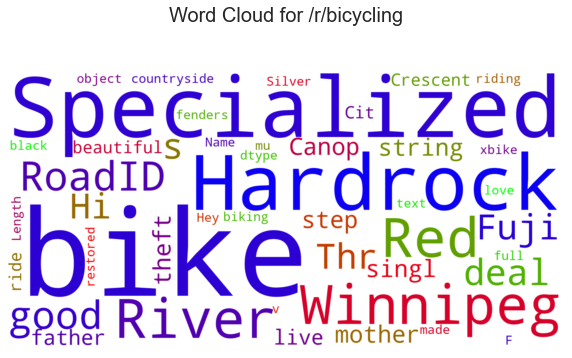

In [33]:
# Draw word cloud for bicycling
draw_wordcloud(str(df[df.subreddit=='bicycling'].text),
               plot_title='Word Cloud for /r/bicycling')

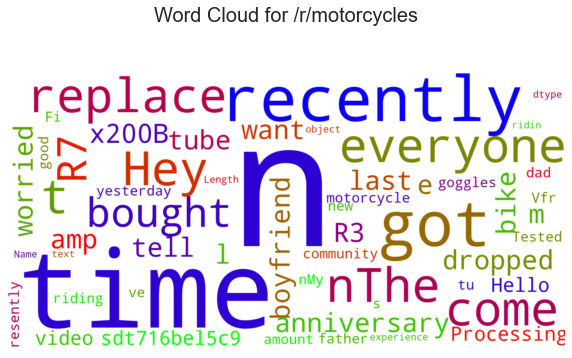

In [34]:
# Draw word cloud for motorcycles
draw_wordcloud(str(df[df.subreddit=='motorcycles'].text),
               plot_title='Word Cloud for /r/motorcycles')

The word clouds did not show much insights. Bicycling posts show that the audience need help and advice, while audiences in the motorcycles subreddit seem to be talking about the greatest of something, presumably motorcycles.

### Exploring word and character length of posts

In [35]:
df.groupby('subreddit').describe()

text_char_len                                                    \
                    count        mean         std  min    25%    50%    75%   
subreddit                                                                     
bicycling          2852.0  262.584151  519.682721  3.0   45.0  105.0  322.0   
motorcycles        2477.0  448.844166  444.735868  6.0  183.0  340.0  582.0   

                     text_word_len                                         \
                 max         count       mean        std  min   25%   50%   
subreddit                                                                   
bicycling    14645.0        2852.0  48.199509  87.527500  1.0   8.0  20.0   
motorcycles   4348.0        2477.0  84.999596  84.738725  1.0  34.0  64.0   

                            
               75%     max  
subreddit                   
bicycling     61.0  2661.0  
motorcycles  111.0   795.0

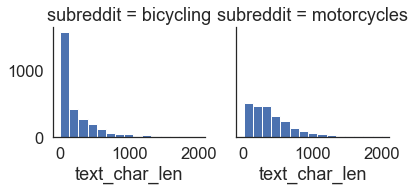

In [36]:
g = sns.FacetGrid(df[df['text_char_len']<2000],col='subreddit')
g.map(plt.hist, 'text_char_len', bins=15, );

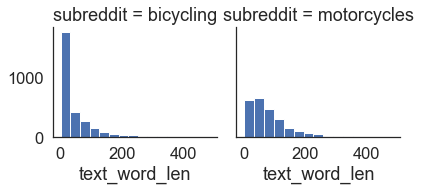

In [37]:
g = sns.FacetGrid(df[df['text_word_len']<500],col='subreddit')
g.map(plt.hist, 'text_word_len', bins=15, );

**We see that bicycling subreddits have lesser characters and word counts than motorcycles subreddit.**

### Exploring stem and lem words

In [38]:
# Use previous function stem_token to create another column from cleaned tokens

df['stemmed_from_cleaned_tokens'] = df['cleaned_tokens'].apply(stem_token)

In [39]:
# Comparing cleaned tokens against its stemmed form

n=4
for i in range(len(df['cleaned_tokens'][n])):
    if df['cleaned_tokens'][n][i] != df['stemmed_from_cleaned_tokens'][n][i]:
        print(df['cleaned_tokens'][n][i], df['stemmed_from_cleaned_tokens'][n][i])

specialized special
canopy canopi
single singl


In [40]:
# Use previous function lem_token to create another column from cleaned tokens

def lem_token(word_list):
    return [lem.lemmatize(word) for word in word_list]

df['lemmed_from_cleaned_tokens'] = df['cleaned_tokens'].apply(lem_token)

In [41]:
# Comparing cleaned tokens against its lemmed form

n=4
for i in range(len(df['cleaned_tokens'][n])):
    if df['cleaned_tokens'][n][i] != df['lemmed_from_cleaned_tokens'][n][i]:
        print(df['cleaned_tokens'][n][i], df['lemmed_from_cleaned_tokens'][n][i])

**We can see that stemming is stricter in cleaning out words. The lemmatizer was only used on the words 'question' and 'cyclist' but the Porter Stemmer was used on more words. We are uncertain which is better, so we will leave it in the dataframe first.**

### Most common words in the original text

In [42]:
# Instantiate CountVectorizer and TfidfVectorizer
cvec = CountVectorizer(stop_words=stoplist)
tfidf = TfidfVectorizer(stop_words=stoplist)

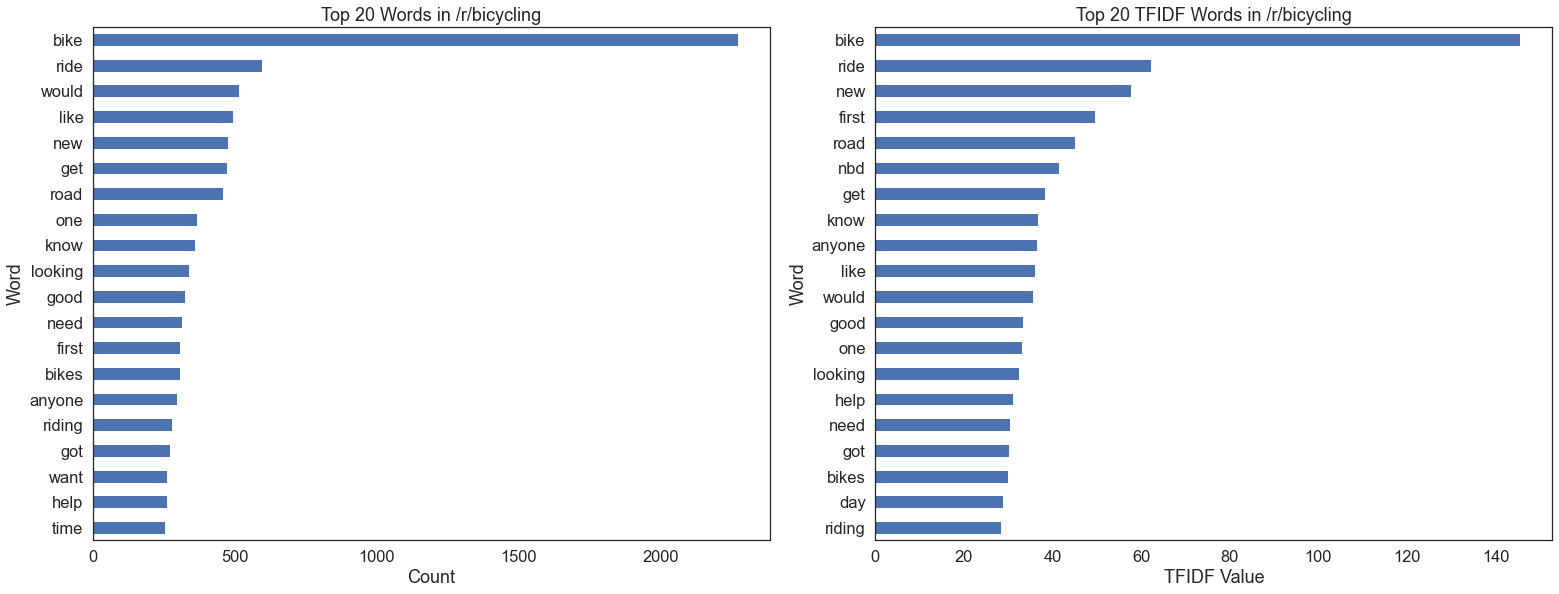

In [43]:
# Explore CountVectorizer token counts in /r/bicycling
words_cvec_bike = pd.DataFrame(cvec.fit_transform(df[df.subreddit=='bicycling'].text).todense(),
                               columns=cvec.get_feature_names())
word_cvec_counts_bike = words_cvec_bike.sum(axis=0)

# Explore TfidfVectorizer token counts in /r/bicycling
words_tfidf_bike = pd.DataFrame(tfidf.fit_transform(df[df.subreddit=='bicycling'].text).todense(),
                       columns=tfidf.get_feature_names())
word_counts_tfidf_bike = words_tfidf_bike.sum(axis=0)

# Plot top 20 words
plt.figure(figsize=(22,16), facecolor='white')

plt.subplot(2,2,1)
word_cvec_counts_bike.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 Words in /r/bicycling')
plt.xlabel('Count')
plt.ylabel('Word')

plt.subplot(2,2,2)
word_counts_tfidf_bike.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 TFIDF Words in /r/bicycling')
plt.xlabel('TFIDF Value')
plt.ylabel('Word')

plt.tight_layout()

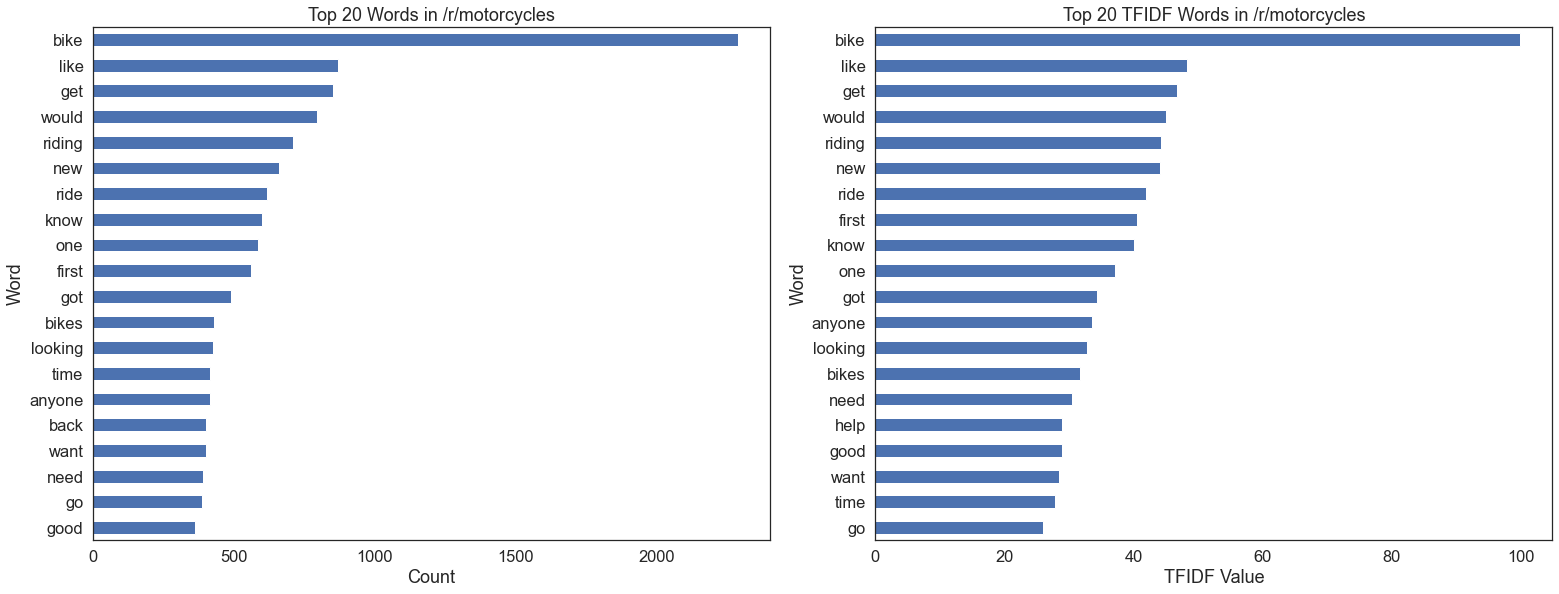

In [44]:
# Explore CountVectorizer token counts in /r/motorcycles
words_cvec_motor = pd.DataFrame(cvec.fit_transform(df[df.subreddit=='motorcycles'].text).todense(),
                                columns=cvec.get_feature_names())
word_cvec_counts_motor = words_cvec_motor.sum(axis=0)

# Explore TfidfVectorizer token counts in /r/motorcycles
words_tfidf_motor = pd.DataFrame(tfidf.fit_transform(df[df.subreddit=='motorcycles'].text).todense(),
                                 columns=tfidf.get_feature_names())
word_counts_tfidf_motor = words_tfidf_motor.sum(axis=0)

# Plot top 20 words
plt.figure(figsize=(22,16), facecolor='white')

plt.subplot(2,2,1)
word_cvec_counts_motor.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 Words in /r/motorcycles')
plt.xlabel('Count')
plt.ylabel('Word')

plt.subplot(2,2,2)
word_counts_tfidf_motor.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 TFIDF Words in /r/motorcycles')
plt.xlabel('TFIDF Value')
plt.ylabel('Word')

plt.tight_layout()

In [45]:
word_counts_tfidf_bike

00         0.177230
000        2.567379
0000       0.289593
000ft      0.021046
000km      0.135360
             ...   
مباريات    0.309394
مواعيد     0.309394
موٹر       0.619126
پلس        0.309563
𝘤𝘺𝘤𝘭𝘦      0.437228
Length: 10659, dtype: float64

## N-grams
*Back to [Contents](#Contents:)*

In [46]:
sentence_cleaned = df['cleaned_tokens'].apply(lambda wordlist: ' '.join(wordlist))

In [47]:
sentence_cleaned.shape

(5329,)

In [48]:
# Instantiate CountVectorizer again, but this time we want 2 and 3 word phrases
cvec_ngram = CountVectorizer(stop_words=stoplist, ngram_range=(2,3), min_df=3)

# Matrix of ngrams
ngrams = cvec_ngram.fit_transform(sentence_cleaned)

# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)

# list of ngrams in dictionary form
# returns the ngram terms (keys) & index position (values)
vocab = cvec_ngram.vocabulary_

# sort into dataframe, pass index into count_values to get freq
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)).\
rename(columns={0: 'frequency', 1:'bigram/trigram'})

In [49]:
df_ngram.head(20)

,frequency,bigram/trigram
0,202,first bike
1,195,road bike
2,190,new bike
3,189,amp x200b
4,126,anyone know
5,107,first time
6,98,feel like
7,93,would like
8,90,need help
9,80,seems like


In [50]:
df_ngram.tail(100)

,frequency,bigram/trigram
6051,3,advice beginner
6052,3,advance input
6053,3,adjustments bike
6054,3,adjust seat
6055,3,actually works
...,...,...
6146,3,10 months
6147,3,10 mins
6148,3,10 grand
6149,3,10 day


Most common n-grams are bigrams. It seems like the most common bigrams are belonging to posts of people asking for advice as a beginner/ first timer. Least frequent n-grams seem to be quite random, but we see terms associated with time and distance/ mileage. 

## Export to csv
- Export out a dataframe for use in model building in the next notebook

*Back to [Contents](#Contents:)*

In [51]:
df['stem_text'] = df['stem_tokens'].apply(lambda word_list: ' '.join(word_list))
df['lem_text'] = df['lem_tokens'].apply(lambda word_list: ' '.join(word_list))

In [52]:
df.head()

,subreddit,selftext,title,text,tokens,cleaned_tokens,stem_tokens,lem_tokens,text_char_len,text_word_len,stemmed_from_cleaned_tokens,lemmed_from_cleaned_tokens,stem_text,lem_text
0,bicycling,NaN,$10 off any RoadID,$10 off any RoadID,"[10, off, any, roadid]","[10, roadid]","[10, off, ani, roadid]","[10, off, any, roadid]",18,4,"[10, roadid]","[10, roadid]",10 off ani roadid,10 off any roadid
1,bicycling,NaN,Is this a good deal on a bike? It’s a Fuji Thr...,Is this a good deal on a bike? It’s a Fuji Thr...,"[is, this, a, good, deal, on, a, bike, it, s, ...","[good, deal, bike, fuji, thrill, se, mountain,...","[is, thi, a, good, deal, on, a, bike, it, s, a...","[is, this, a, good, deal, on, a, bike, it, s, ...",143,30,"[good, deal, bike, fuji, thrill, se, mountain,...","[good, deal, bike, fuji, thrill, se, mountain,...",is thi a good deal on a bike it s a fuji thril...,is this a good deal on a bike it s a fuji thri...
2,bicycling,"Hi, so there's been a string of bike theft in ...",Preventing Bike Theft,"Hi, so there's been a string of bike theft in ...","[hi, so, there, s, been, a, string, of, bike, ...","[hi, string, bike, theft, apartment, garage, t...","[hi, so, there, s, been, a, string, of, bike, ...","[hi, so, there, s, been, a, string, of, bike, ...",661,128,"[hi, string, bike, theft, apart, garag, thief,...","[hi, string, bike, theft, apartment, garage, t...",hi so there s been a string of bike theft in m...,hi so there s been a string of bike theft in m...
3,bicycling,NaN,Specialized Hardrock. Winnipeg Red River singl...,Specialized Hardrock. Winnipeg Red River singl...,"[specialized, hardrock, winnipeg, red, river, ...","[specialized, hardrock, winnipeg, red, river, ...","[special, hardrock, winnipeg, red, river, sing...","[specialized, hardrock, winnipeg, red, river, ...",58,8,"[special, hardrock, winnipeg, red, river, sing...","[specialized, hardrock, winnipeg, red, river, ...",special hardrock winnipeg red river singl trac...,specialized hardrock winnipeg red river single...
4,bicycling,NaN,Specialized Hardrock. Winnipeg Red river Canop...,Specialized Hardrock. Winnipeg Red river Canop...,"[specialized, hardrock, winnipeg, red, river, ...","[specialized, hardrock, winnipeg, red, river, ...","[special, hardrock, winnipeg, red, river, cano...","[specialized, hardrock, winnipeg, red, river, ...",65,9,"[special, hardrock, winnipeg, red, river, cano...","[specialized, hardrock, winnipeg, red, river, ...",special hardrock winnipeg red river canopi sin...,specialized hardrock winnipeg red river canopy...


In [53]:
final_df = df[['subreddit', 'text', 'stem_text', 'lem_text']]
final_df.to_csv('./data/final_df.csv', index = False)